## Imports de bibliothèques python

In [1]:
# Imports
import os
working_dir = os.getcwd()

import h5py

# Personal toolboxes
import sys
sys.path.insert(1, './/..//toolboxes')

from utils_plot import * 
from utils_SHanalysis import *
from utils_geometry import * 
from utils_acoustics import *
from theory_spherical_cap import *

import numpy as np


# Plots 
import matplotlib.pyplot as plt

%matplotlib widget

## Fonctions

In [2]:
def plot_dirballoons(Dinf_list, ind_k,elev = 30, azim = -60, rot= 0, nbtheta_look = 51, nbphi_look = 103,  fig = None, scale = 'dB', dynamic_range = 20, step = 5, legend = '', phase = True):
    if fig == None:
        fig = plt.figure()
    N_method = len(Dinf_list)

    points = np.arange(-dynamic_range, dynamic_range+step, step)

    for ind_method in range(N_method):
        ax = fig.add_subplot(N_method, 1 ,ind_method + 1, projection='3d')
        draw_directivity_balloon(Dinf_list[ind_method][:,ind_k], nbtheta=nbtheta_look, nbphi = nbphi_look, scale = scale, dynamic_range=dynamic_range, ref_sphere= False, ax = ax, phase = phase)
        for point in points :
            ax.text(point, 0, 0, str(np.abs(point)))
            ax.text(0, point, 0, str(np.abs(point)))
            ax.text(0, 0, point, str(np.abs(point)))
        ax.text(30, 0, 0, 'x+')
        ax.text(-30, 0, 0, 'x-')
        
        ax.text(0, 30, 0, 'y+')
        ax.text(0, -30, 0, 'y-')
        ax.text(0, 0, 30, 'z+')
        ax.text(0, 0, -30, 'z-')
        ax.stem3D(points, np.zeros_like(points), np.zeros_like(points), linefmt = 'C1:', markerfmt = 'C0:')
        ax.stem3D(np.zeros_like(points), points, np.zeros_like(points), linefmt = 'C1:', markerfmt = 'C0:')
        ax.stem3D(np.zeros_like(points), np.zeros_like(points), points, linefmt = 'C1:', markerfmt = 'C0:')
        ax.view_init(elev, azim, rot)
        ax.set_axis_off()
        if legend == '' : 
            ax.set_title('Method %d'%ind_method)
        else :
            ax.set_title(legend[ind_method])
            
        plt.tight_layout()

def dB(x) :
    return 20*np.log10(np.abs(x)/np.max(np.abs(x)))

def Dinf_from_meas(x_meas, XYZ_Mems, freqvect, N = 9, nbtheta_look = 51, nbphi_look = 103, lambda_reg = 1e-4, c0 = 343) :
    kvect = 2*np.pi*freqvect/c0
    N_SH_vect = compute_N_SH_vect(freqvect, N, rmin = 1.5)
    H_array = compute_SphericalWavesbasis_origin_to_field(XYZ_Mems, kvect, N)
    cmn = compute_SHcoefs(x_meas, H_array, N_SH_vect = N_SH_vect, lambda_reg=lambda_reg)
    angles_look = create_equal_angle_grid(nbtheta_look, nbphi_look)
    Dinf_meas = compute_Dinf_from_SH_coefs_at_origin(cmn,angles_look, kvect)

    return(cmn, Dinf_meas)

def hammer_spectre(time_signal) :
    i = 60                                              #Nombre de points conservés autour du maximum (1/4 avant, 3/4 après)
    n = len(time_signal)
    argmax = np.argmax(time_signal)
    impact = time_signal[argmax-i//4:argmax+i*3//4]
    return np.fft.rfft(impact, n = n)

def normalize_signal(signal, hammer, ind_freq_study) :
    ref = hammer_spectre(hammer)[ind_freq_study]
    return signal/ref

def moyenne_glissante(sig,n) :
    sig_moy = sig
    for i in range(n) :
        sig_moy[i] = np.mean(sig[0:i+n])
        sig_moy[-i] = np.mean(sig[i-n:])
    for i in np.arange(len(sig))[n:-n] :
        sig_moy[i] = np.mean(sig[i-n:i+n+1])
    return(sig_moy)

def orientation(plan) :
    if plan == 'v' :
        ind_plan = np.hstack((np.arange(51),np.arange(2651,2600,-1)))
        theta = np.linspace(np.pi/2,5/2*np.pi,102)
    elif plan == 'h' :
        hor = []
        for i in range(len(angles_look)) :
            if np.abs(sph2cart(angles_look))[i,2]<1e-3 : hor.append(i)
        ind_plan = hor
        theta = np.linspace(np.pi/2,5/2*np.pi,103)
    else :
        print("Choisir entre le plan vertical ('v') et horizontal ('h')")

    return ind_plan, theta

## Position des micros

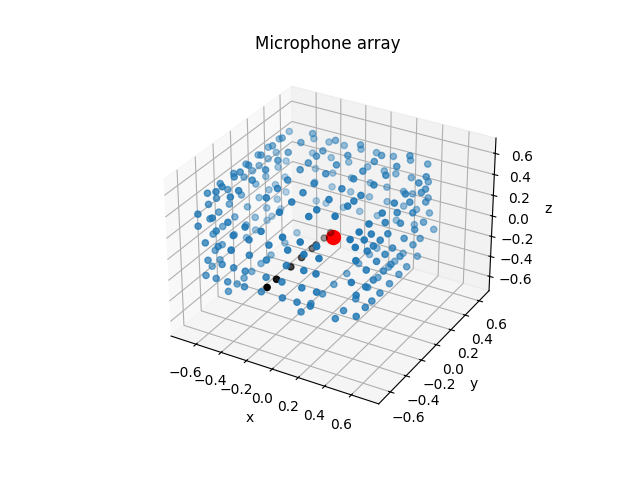

In [3]:
array_file = 'exp_data/calib_geo/XYZm_Calib4.npz'
XYZ = np.load(array_file)['XYZm'][:-1,:] 


ind_samples = [27*8, 12*8, 0, 31*8 + 7, 28*8, 20*8+2 , 2*8, 1*8, 12*8 + 7, 29*8+4, 24*8+3]
XYZ_samples_ref = np.array([[50,30,53], 
                    [-67,-39, -21],
                    [-49, 54, 45],
                    [28,-50,-29],
                    [24, -61, 42],
                    [0,-60,-13],
                    [50,25,-22],
                    [-65,-41,53],
                    [-66,40,-5],
                    [-23,0,-29],
                    [-4,-4,60]], dtype = float)*1e-2

XYZ_ref_retrieved = XYZ[ind_samples[2],:]
XYZ_ref_real = XYZ_samples_ref[2,:]

XYZ[:,1] *=-1
XYZ_centered  = XYZ - XYZ_ref_retrieved + XYZ_ref_real

XYZ_Mems = XYZ_centered[:-1,:]

#Retirer la barre 29 :
ind_removed_rod = np.arange(29*8,29*8+8)
Mems_remove_rod = XYZ_Mems[ind_removed_rod]         #Positions des Mems retirés

pluged_Mems = np.hstack((np.arange(29*8),np.arange(29*8+8,XYZ_Mems.shape[0])))
XYZ_Mems = XYZ_Mems[pluged_Mems]                   




fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
plot_array(XYZ_Mems, ax =ax, array_extend= [0.7,0.65,0.65])
ax.scatter(0,0,0, marker = 'o', color = 'r', s = 100)
removed_rod = ax.scatter(Mems_remove_rod[:,0],Mems_remove_rod[:,1],Mems_remove_rod[:,2], marker = 'o', color = 'black')
# removed_rod.remove()
# ax.view_init(0, 0)


## Chargement des mesures

SNR moyen : 69.80071706901869 dB


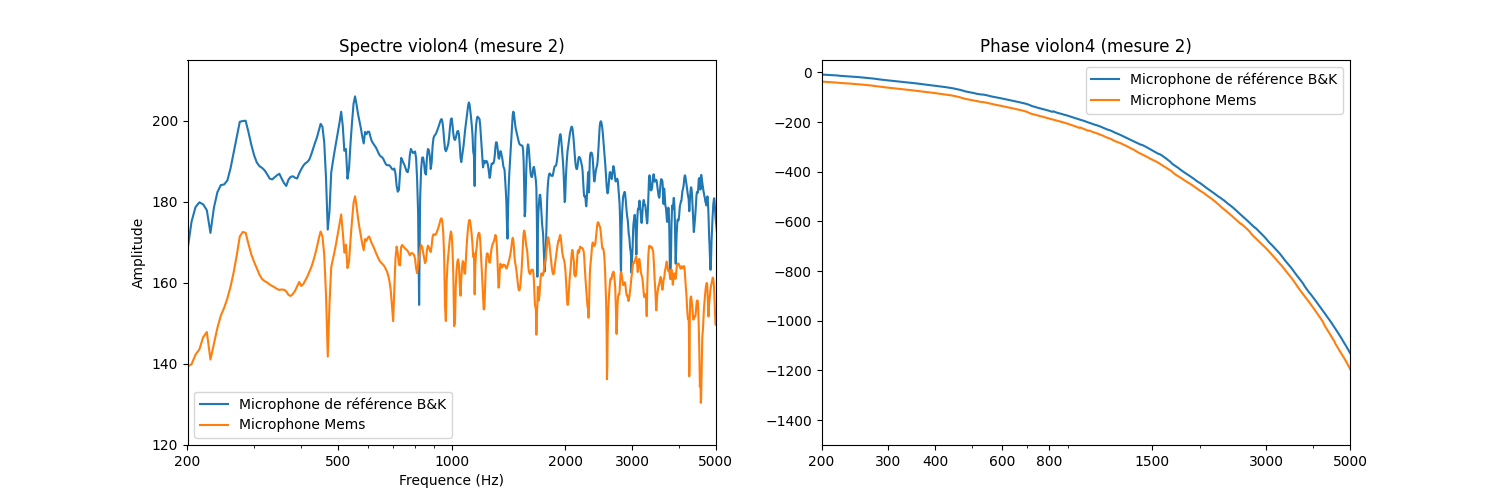

In [23]:
# Paramètres fréquentiels et ordre de troncature
freqvect = np.arange(100, 5001, 10) # Hz
N = 6

fs = 50e3
Nsamples = 10000  #Signaux de 0.2 sec pour le marteau


all_freq = np.fft.rfftfreq(Nsamples, 1/fs)
ind_freq_study = []
for ind_freq in range(len(freqvect)):
    ind_freq_study.append(np.argmin(np.abs(freqvect[ind_freq] - all_freq)))


# Violon et numéro de mesure :
violon = 'violon4'
num_mesure = 2
Ref_file = f'{violon}/hammer/Ref_{num_mesure}'
Mems_file = f'{violon}/hammer/Measure_{num_mesure}'


#Fichiers des signaux
time_folder = 'C:/Augustin/TN10/violons/Database_time.hdf5'
freq_folder = 'C:/Augustin/TN10/violons/Database_freq.hdf5'
noise_file = 'C:/Augustin/TN10/violons/hammer_noise.hdf5'


Ref_time = h5py.File(time_folder, 'r')[Ref_file]#[:,ind_freq_study]
Mems_time = h5py.File(time_folder, 'r')[Mems_file][pluged_Mems]#[:,ind_freq_study]
Ref_freq = h5py.File(freq_folder, 'r')[Ref_file]#[:,ind_freq_study]
Mems_freq = h5py.File(freq_folder, 'r')[Mems_file][pluged_Mems]#[:,ind_freq_study]

vectf = np.fft.rfftfreq(Ref_time.shape[1], 1/fs)


#SNR :
noise = h5py.File(noise_file)[f'time_sig_{violon}'][pluged_Mems]
Nbsecs_noise = noise.shape[1]/fs
Nbsecs_hammer = 0.2
P_noise = 10*np.log10(np.sum(np.square(np.abs(noise)), axis = 1)/Nbsecs_noise)
P_hammer = 10*np.log10(np.sum(np.square(np.abs(Mems_freq)), axis = 1)/Nbsecs_hammer)
SNR = P_hammer - P_noise
print(f'SNR moyen : {np.mean(SNR)} dB')


#Spectres
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.semilogx(vectf, 10*np.log(np.abs(Ref_freq[0].T)))
ax.semilogx(vectf, 10*np.log(np.abs(Mems_freq[4*8+3].T)))
ax.set_title(f'Spectre {violon} (mesure {num_mesure})')
ax.set_ylim([120,215])
ax.set_xticks([200,500,1000,2000,3000,5000])
ax.set_xticklabels([200,500,1000,2000,3000,5000])
ax.set_xlim([200, 5000])
ax.set_xlabel('Frequence (Hz)')
ax.set_ylabel('Amplitude')
ax.legend(['Microphone de référence B&K','Microphone Mems'])
ax = fig.add_subplot(1,2,2)
ax.semilogx(vectf, np.unwrap(np.angle(Ref_freq[0].T)))
ax.semilogx(vectf, np.unwrap(np.angle(Mems_freq[4*8+3].T)))
ax.set_title(f'Phase {violon} (mesure {num_mesure})')
ax.set_xticks([100,200,300,400,600,800,1500,3000,5000])
ax.set_xticklabels([100,200,300,400,600,800,1500,3000,5000])
ax.set_xlim([200, 5000])
ax.set_ylim([-1500,50])
ax.legend(['Microphone de référence B&K','Microphone Mems'])

## Signal temporel

Text(0, 0.5, 'Amplitude')

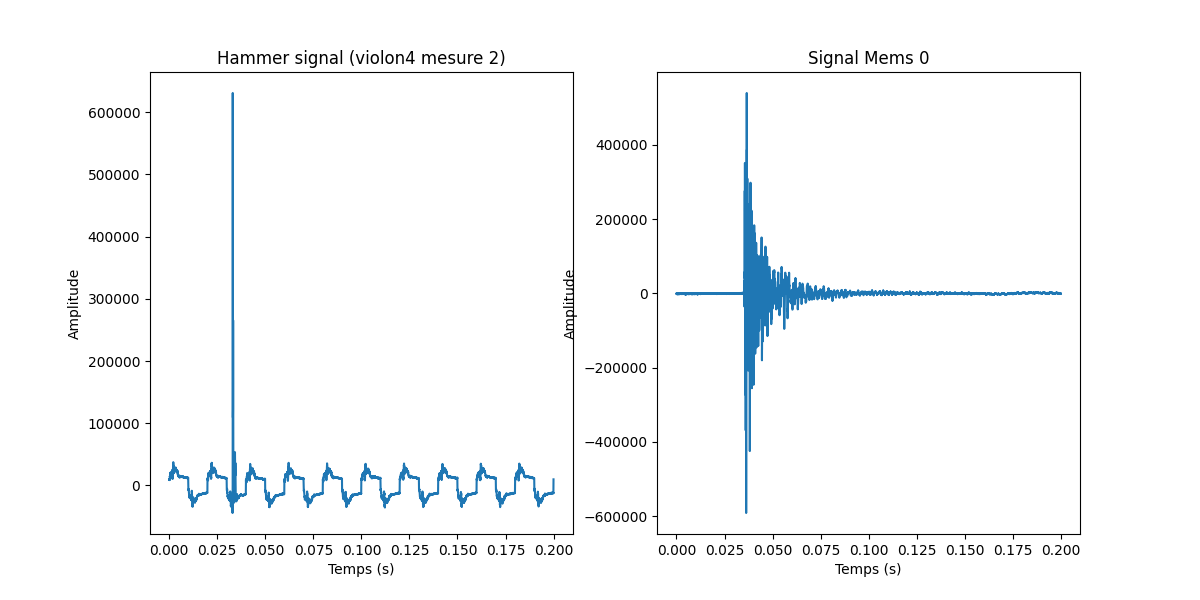

In [5]:
fig = plt.figure(figsize=((12,6)))
ax = fig.add_subplot(1,2,1)
plot = ax.plot(np.arange(Mems_time.shape[1])/fs,Ref_time[2].T)      #Ref 0 : B&K, 1 : DPA, 2 : marteau
ax.set_title(f'Hammer signal ({violon} mesure {num_mesure})')
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Amplitude')
ax = fig.add_subplot(1,2,2)
plot = ax.plot(np.arange(Mems_time.shape[1])/fs,Mems_time[0].T)
ax.set_title('Signal Mems 0')
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Amplitude')

## Moyennage des spectres

"\nfig = plt.figure(figsize=(15,5))\nax = fig.add_subplot(1,2,1)\nax.semilogx(vectf, 10*np.log(np.abs(Ref_freq[2].T)))\nax.set_title(f'Spectre marteau {violon} mesure {num_mesure} (siganl complet, 0.2 sec)')\nax.set_xlabel('Fréquence (Hz)')\nax.set_ylabel('Amplitude')\nax.set_xlim([200, 5e3])\nax.set_ylim([120,170])\nax = fig.add_subplot(1,2,2)\nax.semilogx(vectf, 10*np.log(np.abs(hammer_spectre(Ref_time[2]))))\nax.set_xlim([200, 5e3])\nax.set_ylim([120,170])\nax.set_xlabel('Fréquence (Hz)')\nax.set_ylabel('Amplitude')\nax.set_title(f'Spectre marteau {violon} mesure {num_mesure} (impact isolé)')\n"

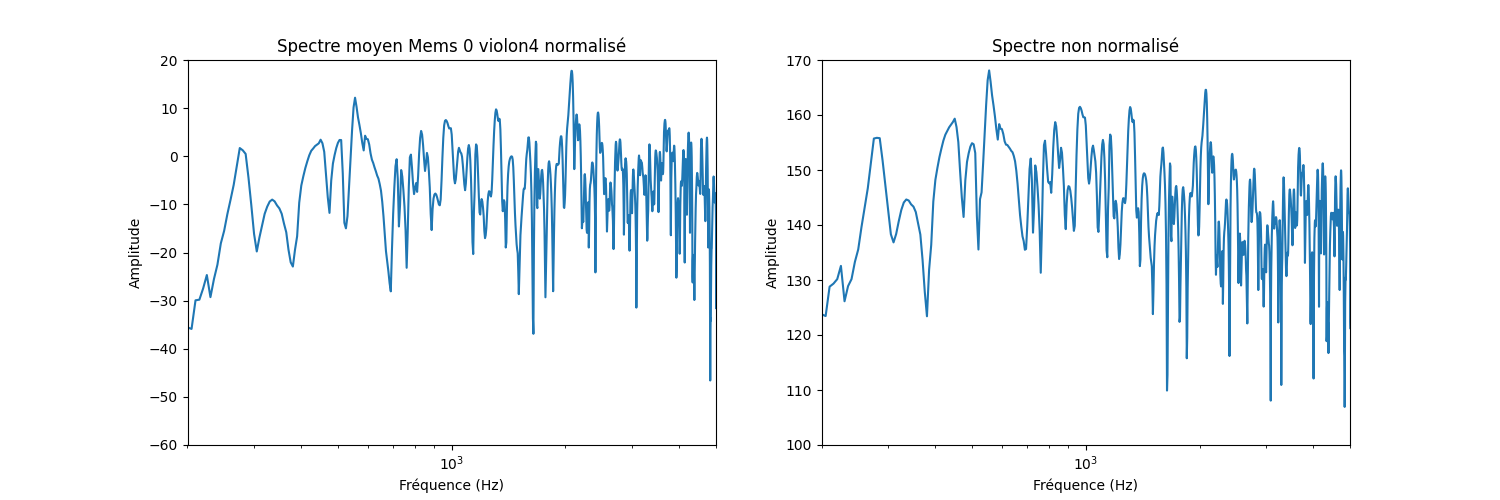

In [24]:
mean_spectre = {}           #Spectre moyen normalisé
real_meas = {}              #Spectre non normalisé

SH_dic = {}
Dinf_dic = {}


violon_list = [1,4,5,9,11,13]
for violon_num in violon_list :
    meas = [h5py.File(freq_folder, 'r')[f'violon{violon_num}/hammer/Measure_{i}'][pluged_Mems] for i in range(1,6)]     #Spectre des violons
    ref = [h5py.File(time_folder, 'r')[f'violon{violon_num}/hammer/Ref_{i}'][2] for i in range(1,6)]                    #Signal temporel du marteau
    mean_spectre[f'violon{violon_num}'] = np.mean([meas[i]/hammer_spectre(ref[i]) for i in range(5)], axis = 0)
    real_meas[f'violon{violon_num}'] = np.mean([h5py.File(freq_folder, 'r')[f'violon{violon_num}/hammer/Measure_{i}'][pluged_Mems] for i in range(1,6)], axis = 0)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.semilogx(vectf, 10*np.log(np.abs(mean_spectre[violon][0].T)))
ax.set_title(f'Spectre moyen Mems 0 {violon} normalisé')
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Amplitude')
ax.set_xlim([200, 5e3])
ax.set_ylim([-60,20])
ax = fig.add_subplot(1,2,2)
ax.semilogx(vectf, 10*np.log(np.abs(real_meas[violon][0].T)))
ax.set_xlim([200, 5e3])
ax.set_ylim([100,170])
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title(f'Spectre non normalisé')


# Spectre marteau :
"""
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.semilogx(vectf, 10*np.log(np.abs(Ref_freq[2].T)))
ax.set_title(f'Spectre marteau {violon} mesure {num_mesure} (siganl complet, 0.2 sec)')
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Amplitude')
ax.set_xlim([200, 5e3])
ax.set_ylim([120,170])
ax = fig.add_subplot(1,2,2)
ax.semilogx(vectf, 10*np.log(np.abs(hammer_spectre(Ref_time[2]))))
ax.set_xlim([200, 5e3])
ax.set_ylim([120,170])
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title(f'Spectre marteau {violon} mesure {num_mesure} (impact isolé)')
"""

## Calcul de directivité / répétitions

In [7]:
SH_list = []
Dinf_list = []

num_repet = 5
for violon_num in [1,4,5,9,11,13] :
    for ind_repet in range(1,num_repet+1) :
        Mems_file = f'violon{violon_num}/hammer/Measure_{ind_repet}'
        Ref_file = f'violon{violon_num}/hammer/Ref_{ind_repet}'
        Mems = h5py.File(freq_folder, 'r')[Mems_file][pluged_Mems][:,ind_freq_study]
        Ref = h5py.File(time_folder, 'r')[Ref_file][2]
        normal_spectre = normalize_signal(Mems,Ref, ind_freq_study)
        SH, Dinf = Dinf_from_meas(normal_spectre, XYZ_Mems, freqvect, N=N)
        SH_dic[f'violon{violon_num}_{ind_repet}'] = SH
        Dinf_dic[f'violon{violon_num}_{ind_repet}'] = Dinf
        SH_list.append(SH)
        Dinf_list.append(Dinf)


c:\Users\augus\Desktop\Stage_augustin\notebooks\utils_SHanalysis.py:221: RuntimeWarning: divide by zero encountered in divide
  kr_farfield = eta*(scsp.factorial(2*n_SH_vect)/(2**n_SH_vect*scsp.factorial(n_SH_vect)))**(1/n_SH_vect) # check eqs 7 8 Hartenstein et al FA 2023


## Directivité moyenne

In [26]:
for violon_num in violon_list :
    Mems = mean_spectre[f'violon{violon_num}'][:,ind_freq_study]
    SH, Dinf = Dinf_from_meas(Mems, XYZ_Mems, freqvect, N=N)
    SH_dic[f'violon{violon_num}'] = SH
    Dinf_dic[f'violon{violon_num}'] = Dinf

c:\Users\augus\Desktop\Stage_augustin\notebooks\utils_SHanalysis.py:221: RuntimeWarning: divide by zero encountered in divide
  kr_farfield = eta*(scsp.factorial(2*n_SH_vect)/(2**n_SH_vect*scsp.factorial(n_SH_vect)))**(1/n_SH_vect) # check eqs 7 8 Hartenstein et al FA 2023


Moyennage des directivité après calcul pour chaque impact

In [9]:
for violon_num in violon_list :
    Dinf_dic[f'violon{violon_num}_mean_dir'] = np.mean(np.abs([Dinf_dic[f'violon{violon_num}_{i+1}'] for i in range(5)]), axis = 0)

Export des coefficients harmoniques sphériques

In [11]:
import csv
import pandas as pd

for violon in violon_list :
    new_dic = {}
    for f,SH in enumerate(SH_dic[f'violon{violon}'].T) :
        new_dic[freqvect[f]] = SH[:4]/np.sqrt(np.sum(np.square(np.abs(SH)), axis = 0))
    df = pd.DataFrame.from_dict(new_dic) 
    df.to_csv (f'SH_violin{violon}.csv', index=True, header=True)

# SH coefs

"\nfig = plt.figure(figsize=(10,6))\nax = fig.add_subplot()\nz = np.abs(SH_norm[2])\nx = np.abs(SH_norm[1]-SH_norm[3])/2\ny = np.abs(SH_norm[1]+SH_norm[3])/2\nax.loglog(freqvect,moyenne_glissante(x,1))\nax.loglog(freqvect,moyenne_glissante(y,1))\nax.loglog(freqvect,moyenne_glissante(z,1))\nfig.legend(['x','y','z'])\nax.set_title('Contribution dipôles (violon 11)')\nax.set_xlabel('Fréquence (Hz)')\nax.set_ylabel('Amplitude')\nticks = [200,500,1000,2000,5000]\nax.set_xlim([200,5000])\nax.set_xticks(ticks)\nax.set_xticklabels(ticks)\n"

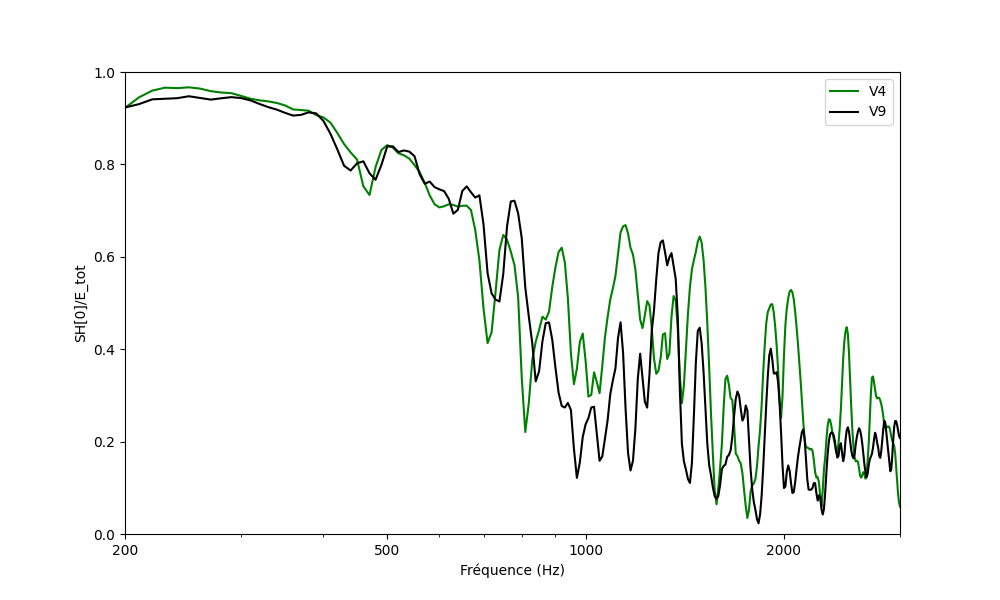

In [12]:
SH_4 = SH_dic['violon4']
SH_9 = SH_dic['violon9']

SH = SH_dic['violon11']
SH_norm = SH/np.sqrt(np.sum(np.square(np.abs(SH)), axis = 0))
SH_norm_4 = SH_4/np.sqrt(np.sum(np.square(np.abs(SH_4)), axis = 0))
SH_norm_9 = SH_9/np.sqrt(np.sum(np.square(np.abs(SH_9)), axis = 0))


# Contribution/Amplitude du monopole ou dipole longitudinal :
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
coef = 0                #Monopole 
# coef = 2              #Dipole en z

# Contribution
plot = (np.abs(SH_norm_4[coef]))
plt.semilogx(freqvect,moyenne_glissante(plot,1),'g')
plot = (np.abs(SH_norm_9[coef]))
plt.semilogx(freqvect,moyenne_glissante(plot,1),'black')
plt.ylabel(f'SH[{coef}]/E_tot')
plt.ylim([0,1])

# Amplitude
# plot = np.abs(SH_4[coef])
# plt.semilogx(freqvect,moyenne_glissante(plot,1),'g')
# plot = np.abs(SH_9[coef])
# plt.semilogx(freqvect,moyenne_glissante(plot,1),'black')
# plt.ylabel(f'SH[{coef}]')

plt.xlabel('Fréquence (Hz)')
ticks = [200,500,1000,2000,5000]
plt.xticks(ticks)
ax.set_xticklabels(ticks)
plt.xlim([200,3000])
plt.legend(['V4', 'V9'])


# Contribution des 3 dipôles
"""
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
z = np.abs(SH_norm[2])
x = np.abs(SH_norm[1]-SH_norm[3])/2
y = np.abs(SH_norm[1]+SH_norm[3])/2
ax.loglog(freqvect,moyenne_glissante(x,1))
ax.loglog(freqvect,moyenne_glissante(y,1))
ax.loglog(freqvect,moyenne_glissante(z,1))
fig.legend(['x','y','z'])
ax.set_title('Contribution dipôles (violon 11)')
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Amplitude')
ticks = [200,500,1000,2000,5000]
ax.set_xlim([200,5000])
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
"""

### NCC / répétitions

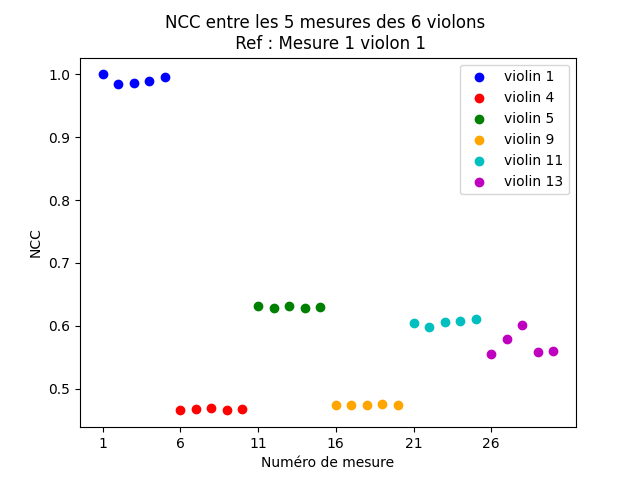

In [13]:
NCC = []
colors = ['b','r','g','orange', 'c','m']

for i in range(len(SH_list)) :
    NCC.append(np.mean(compute_NCC(SH_list[0],SH_list[i])))

fig = plt.figure()
ax = fig.add_subplot()
for i in range(6) :
    ax.scatter(np.arange(num_repet)+num_repet*i+1, NCC[(num_repet)*i:(num_repet)*(i+1)], c=colors[i])
plt.legend(['violin 1','violin 4', 'violin 5', 'violin 9', 'violin 11', 'violin 13'])
ax.set_title('NCC entre les 5 mesures des 6 violons \n Ref : Mesure 1 violon 1')
ax.set_xlabel('Numéro de mesure')
ax.set_ylabel('NCC')
ticks =  ax.set_xticks(np.arange(1, 6*num_repet +1,5))


NCC violon 13

[0.98131656 0.94781752 0.98148905 0.98113906]


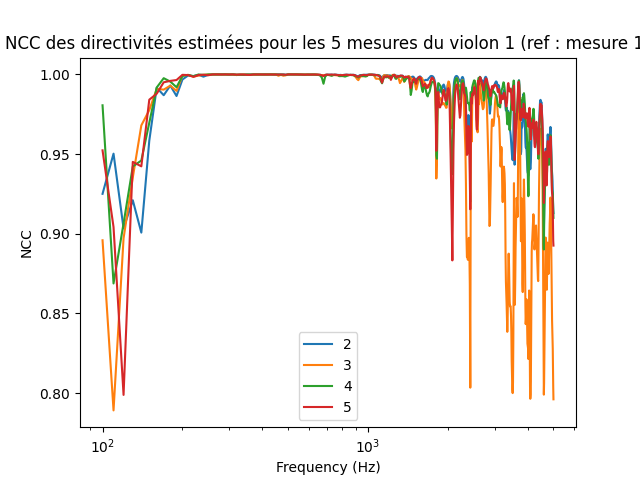

In [14]:
plt.figure()

NCC = np.array([compute_NCC(SH_dic[f'violon13_1'],SH_dic[f'violon13_{i}']) for i in range(2,6)])
print(np.mean(NCC , axis=1))
plt.semilogx(freqvect,NCC.T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('NCC')
plt.title('NCC des directivités estimées pour les 5 mesures du violon 1 (ref : mesure 1)')
plt.legend(range(2,6))

### NCC violons

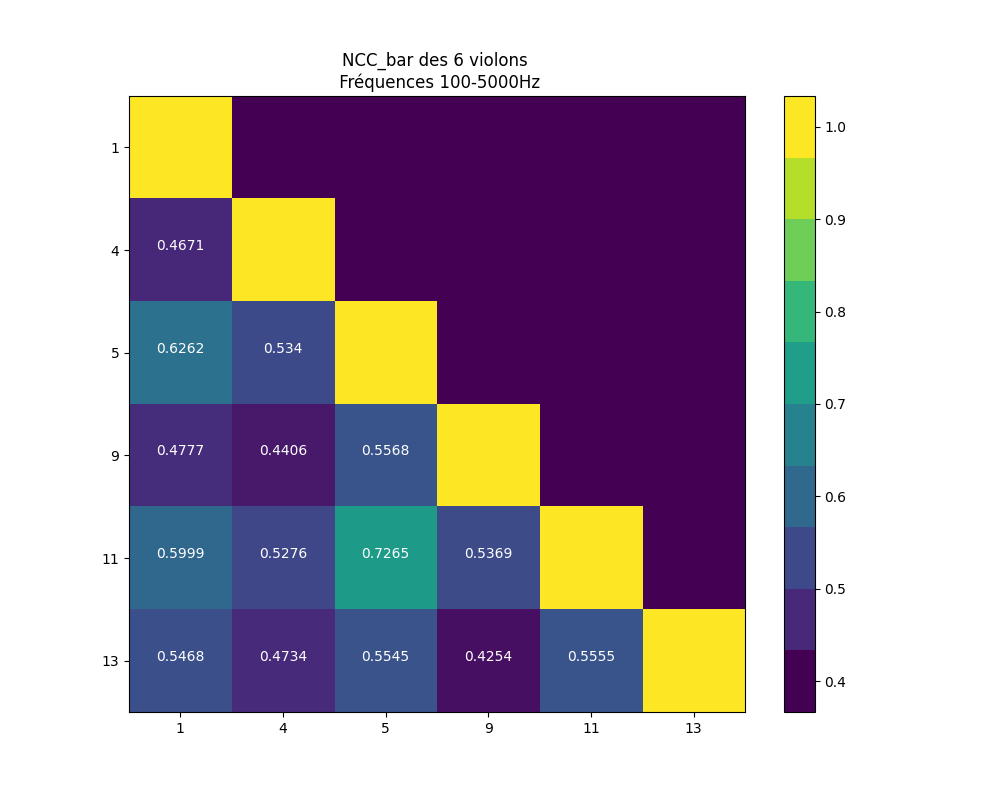

In [15]:
NCC_map_mean_spectre = -np.ones((6,6))
NCC_map_mean_dir = -np.ones((6,6))

for ind_ref,violon_ref in enumerate(violon_list) :
    for ind_comp,violon_comp in enumerate(violon_list[:ind_ref+1]) :
        NCC_map_mean_spectre[ind_ref, ind_comp] = np.mean(compute_NCC(SH_dic[f'violon{violon_ref}'],SH_dic[f'violon{violon_comp}']))
vmin = 0.4
vmax = 1

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
map = ax.imshow(NCC_map_mean_spectre, vmin = vmin, vmax = vmax)
ax.set_xticks(range(6),labels = violon_list)
ax.set_yticks(range(6),labels = violon_list)
fig.colorbar(map, values = np.linspace(vmin,vmax,10))
ax.set_title(f'NCC_bar des 6 violons \n Fréquences {freqvect[0]}-{freqvect[-1]}Hz')
for i in range(NCC_map_mean_spectre.shape[0]) :
    for j in range(NCC_map_mean_spectre.shape[1]) :
        if np.abs(NCC_map_mean_spectre[i,j]) != 1 : ax.text(j,i,np.round(NCC_map_mean_spectre[i,j],4),ha = 'center', c = 'white')


# NCC  fréquence

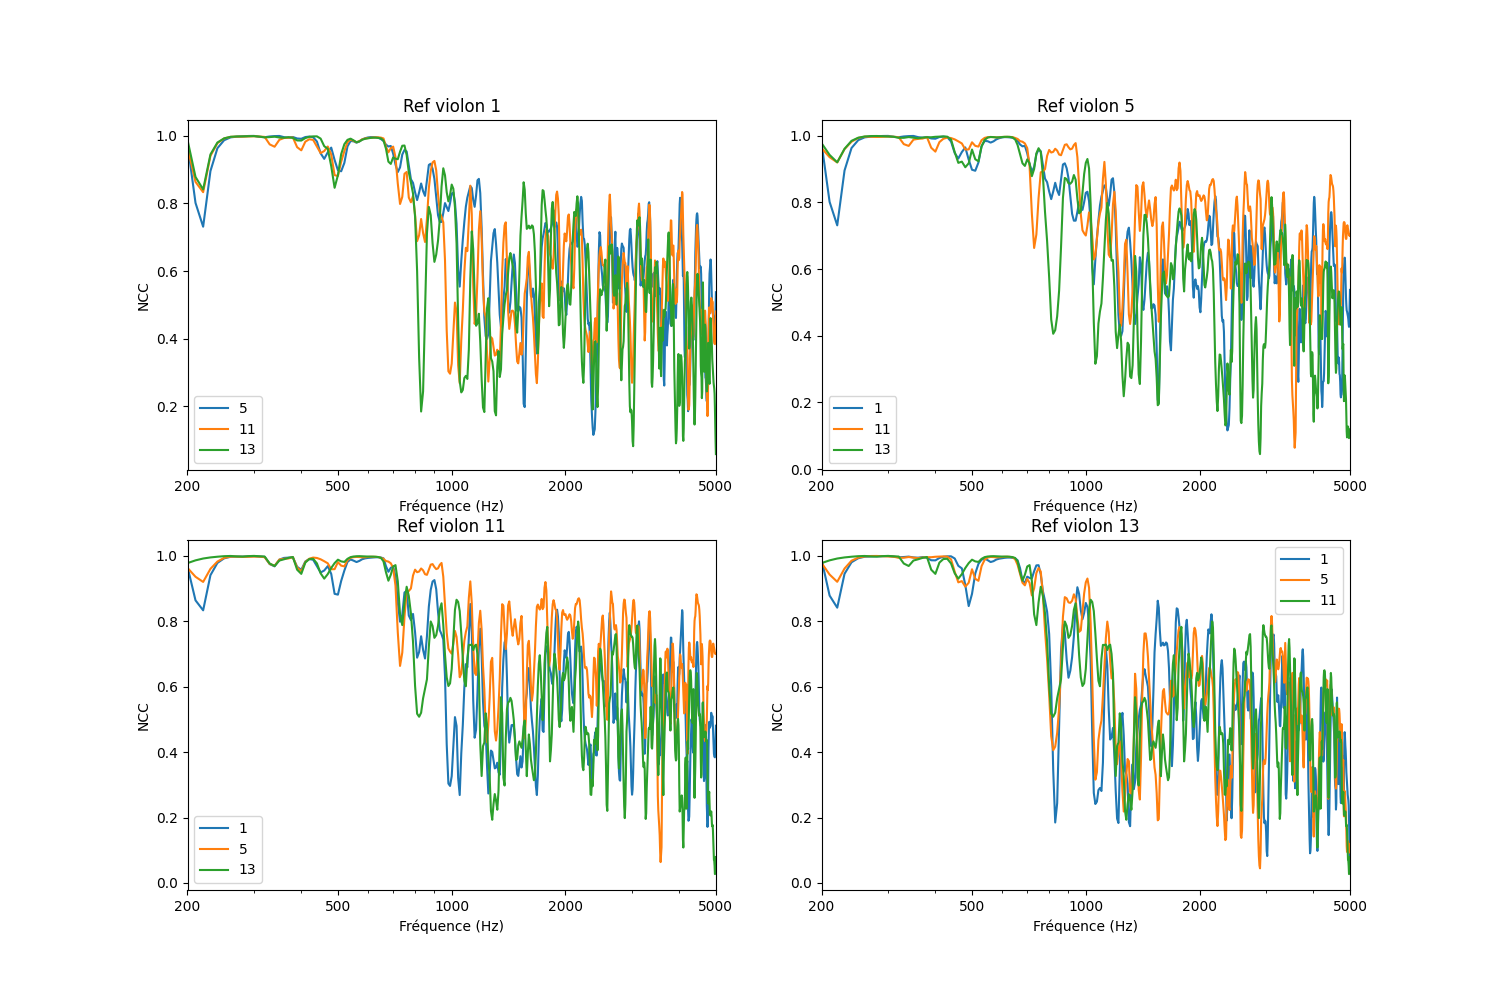

In [27]:
n = 1                   #nombre de points autour de la valeur pour la moyenne glissante
fig = plt.figure(figsize = (15,10))

lp_violon = [1,5,11,13]  #violons à comparer

for i,violon_num in enumerate(lp_violon) :
    list_temp = list(np.copy(lp_violon))
    list_temp.pop(i)
    NCC = np.array([moyenne_glissante(compute_NCC(SH_dic[f'violon{violon_num}'],SH_dic[f'violon{violon_ref}']),n) for violon_ref in list_temp])
    ax = fig.add_subplot(2,2,i+1)
    ax.semilogx(freqvect,NCC.T)
    ax.set_xlabel('Fréquence (Hz)')
    ax.set_ylabel('NCC')
    ax.legend(list_temp)
    ticks = [200,500,1000,2000,5000]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_xlim([200,5000])
    ax.set_title(f'Ref violon {violon_num}')

### Balloon plots

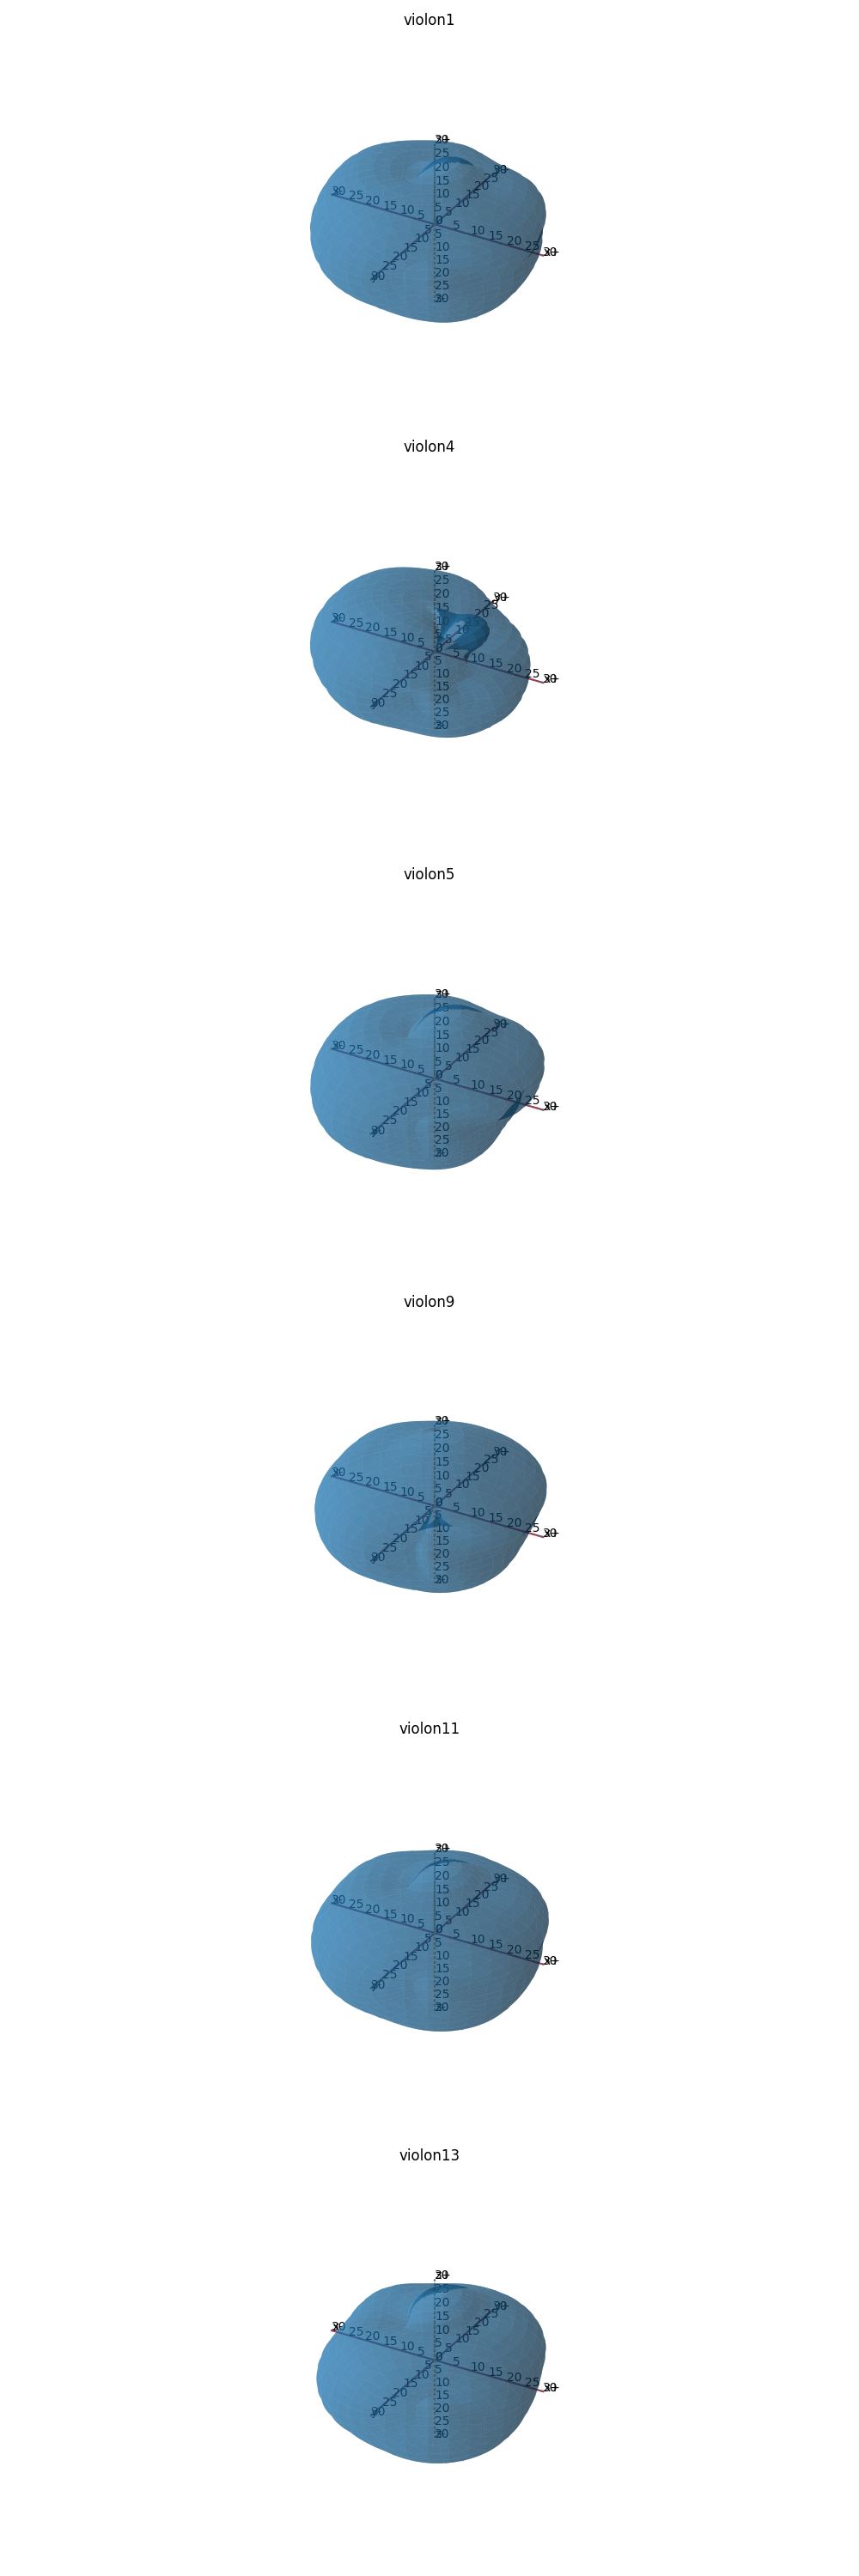

In [17]:
# freq_plot = [300,500,700,900,1100]
f = 700
ind_k = np.argmin(np.abs(f-freqvect))
            

#Liste des directivités à tracer :    
plot_list = ['violon1','violon4','violon5','violon9','violon11','violon13']
# plot_list = ['violon1_1','violon4_1','violon5_1','violon9_1','violon11_1','violon13_1']  
# plot_list = ['violon1_mean_dir','violon4_mean_dir','violon5_mean_dir','violon9_mean_dir','violon11_mean_dir','violon13_mean_dir']
# plot_list = ['violon5_1','violon5_2','violon5_3','violon5_4','violon5_5', 'violon5']

Dinf_plot = [Dinf_dic[plot_ind] for plot_ind in plot_list]

# for ind_f,f in enumerate(freq_plot) :
#     ind_k = np.argmin(np.abs(f-freqvect))
#     fig = plt.figure()
#     plot_dirballoons(Dinf_plot,ind_k, scale = 'dB', dynamic_range=30, fig = fig, legend= f'{f} Hz', phase = False)
#     plt.title(f'{f} Hz')

fig = plt.figure(figsize=(10,5*len(plot_list)))
plot_dirballoons(Dinf_plot,ind_k, scale = 'dB', dynamic_range=30, fig = fig, legend=plot_list, phase = False)


### Plot 2D

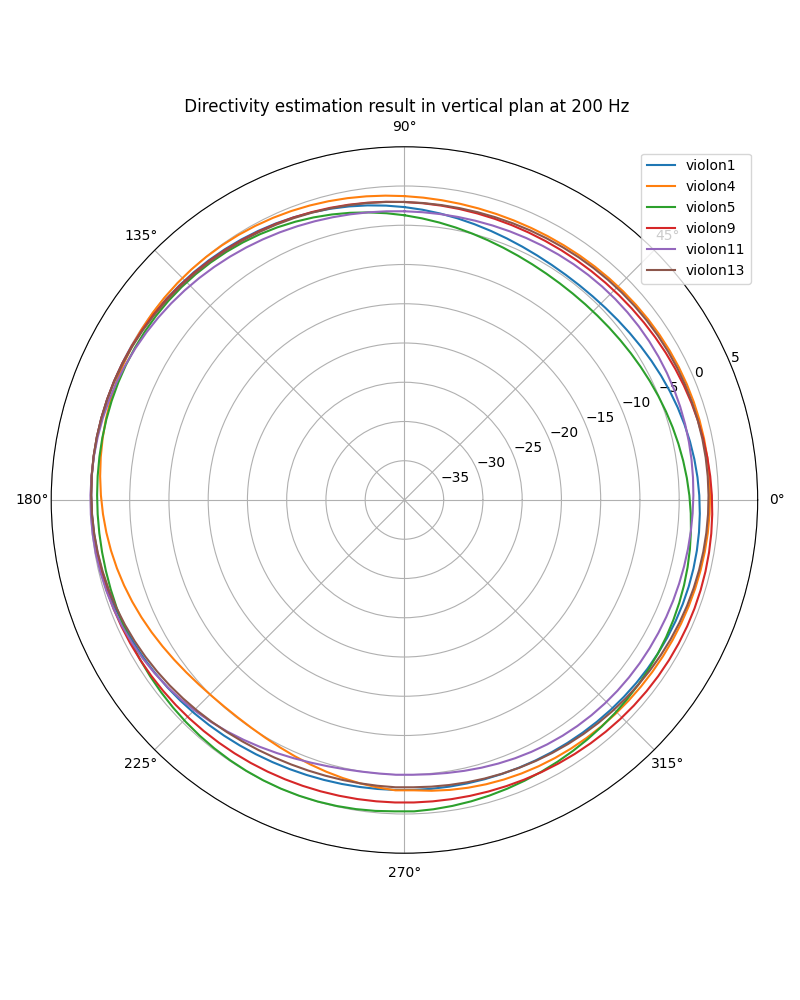

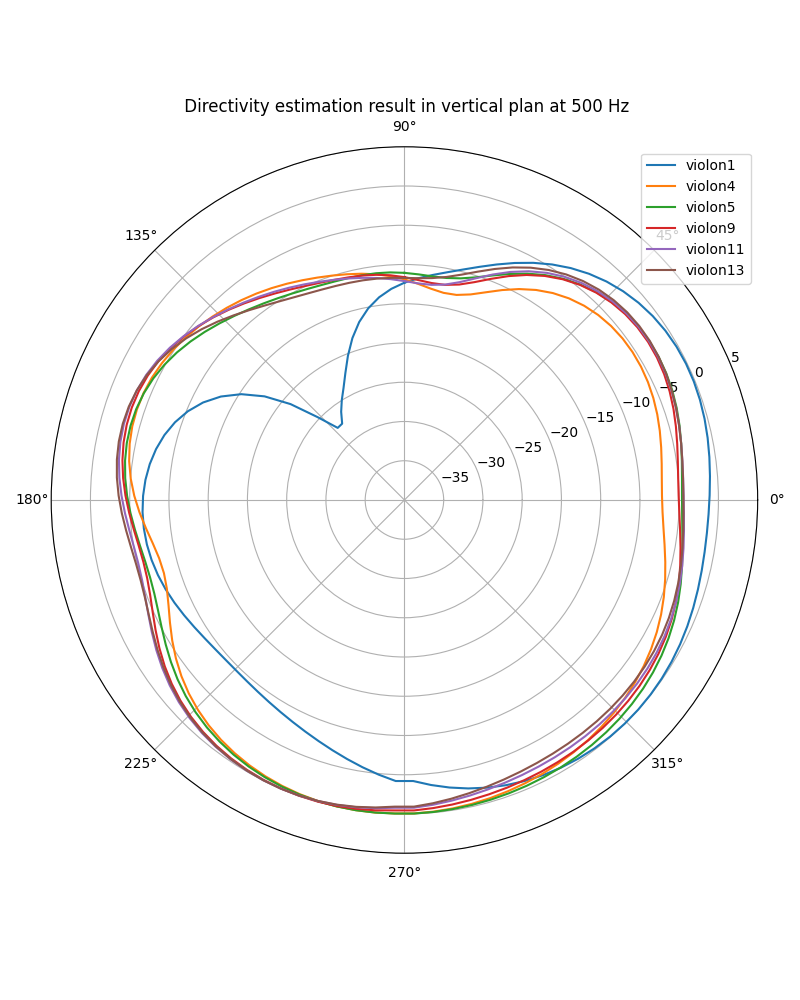

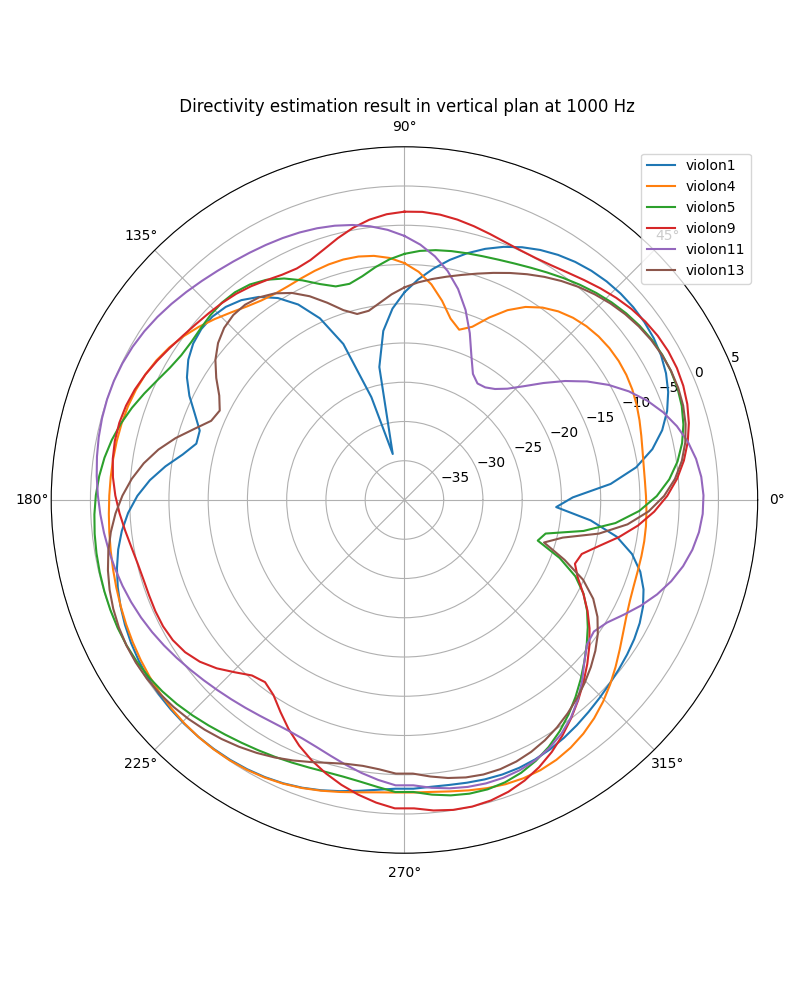

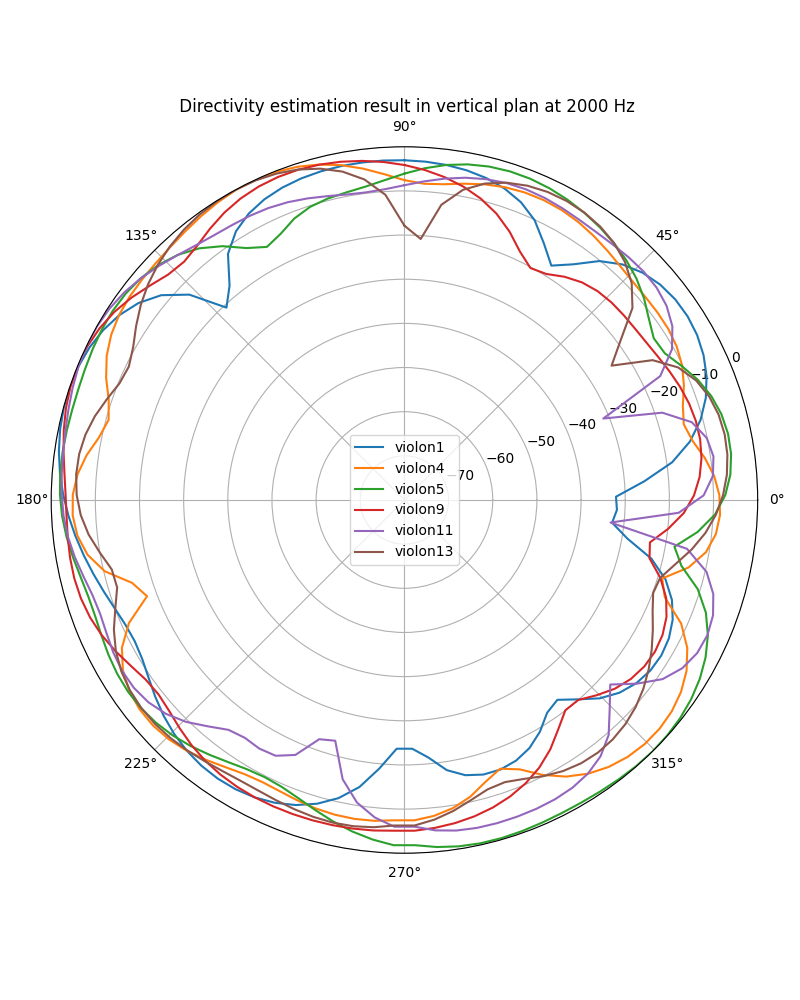

In [18]:
(plan, theta) = orientation('v')  #Choix du plan vertical ou horizontal

freqplot = [200,500,1000,2000]

for f in freqplot :
    ind_f = np.argmin(np.abs(f-freqvect))
    fig = plt.figure(figsize= (8,10))
    ax = fig.add_subplot(1, 1, 1, projection = 'polar')
    for Dinf in Dinf_plot :
        ax.plot(theta, dB(Dinf[plan,ind_f]))
    ax.legend(plot_list)
    ax.set_title(f" Directivity estimation result in vertical plan at {f} Hz")

    if f>1000 : (rmin,rmax) = (-80,0)
    else : (rmin, rmax) = (-40, 5)
    ax.set_rmax(rmax)
    ax.set_rmin(rmin)
    plt.tight_layout()

Text(0.5, 0, 'Frequency (Hz)')

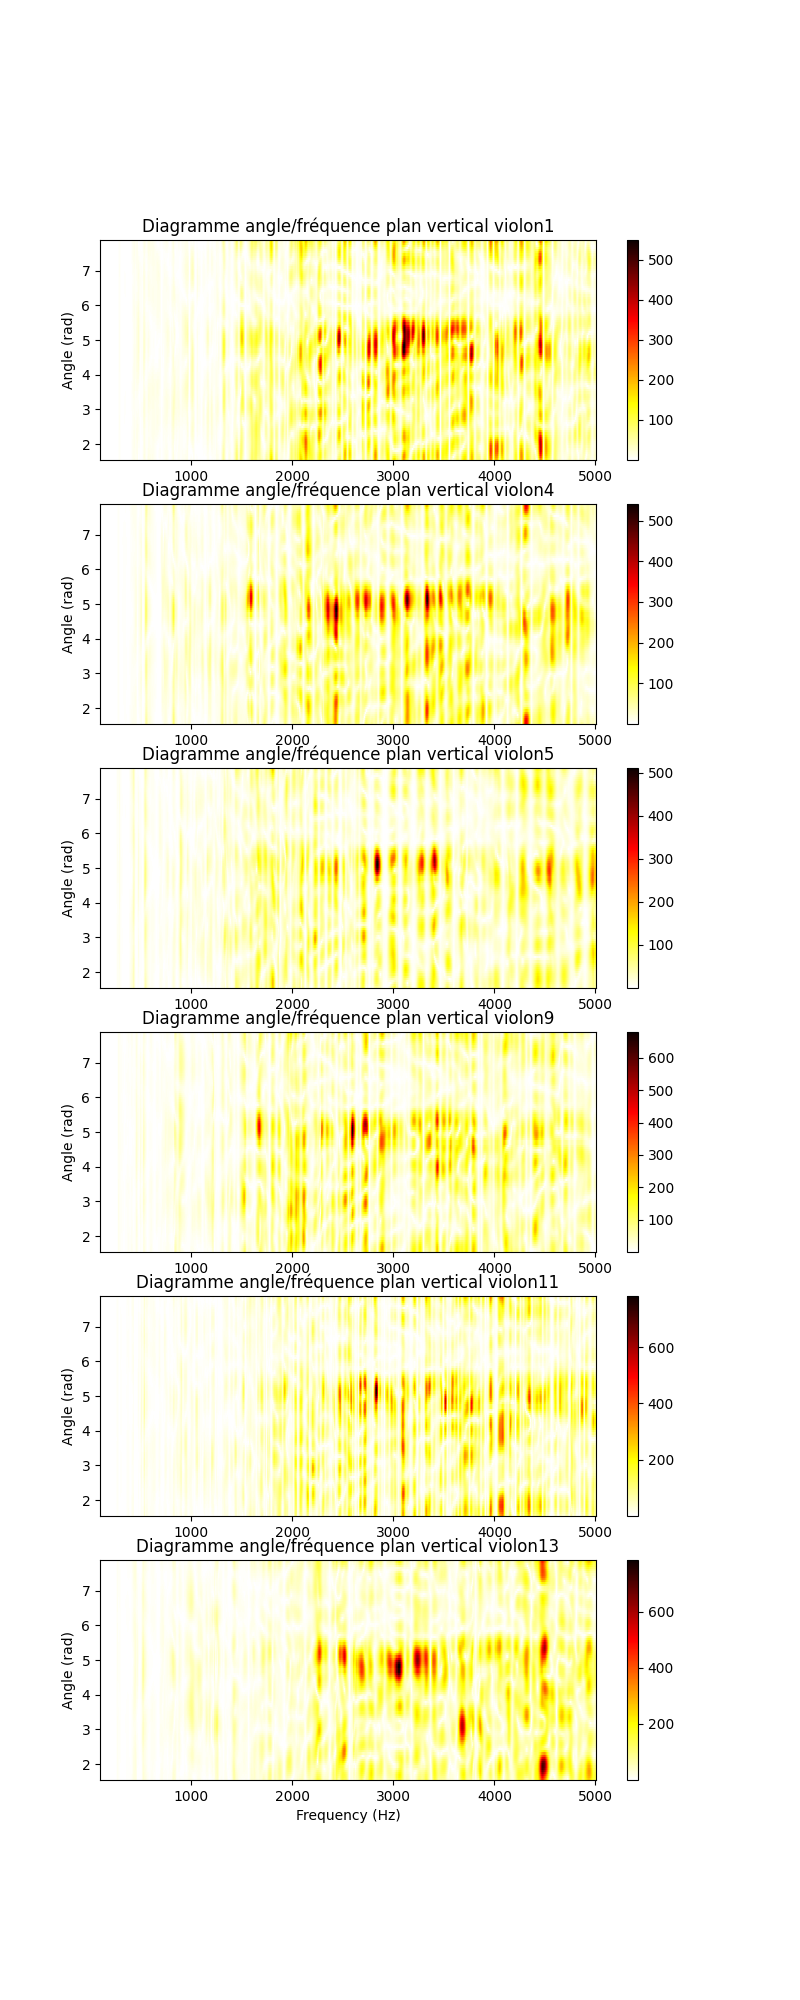

In [21]:
(plan, theta) = orientation('v')



fig = plt.figure(figsize=(8,20))

for i,Dinf in enumerate(Dinf_plot) :
    colorplot = np.abs(Dinf[plan])
    ax = fig.add_subplot(len(Dinf_plot),1,i+1)
    cs = ax.pcolor(freqvect,theta,colorplot, cmap = 'hot_r')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f"Diagramme angle/fréquence plan vertical {plot_list[i]}")
    ax.set_ylabel('Angle (rad)')
ax.set_xlabel('Frequency (Hz)')